In [1]:
___Author___='LumberJack Jyss'

In [2]:
print('Global Optimized LumberJack Equities Method\n°OoO_FOREX_Oo0°\nLumberJack Jyss 5779(c)')

Global Optimized LumberJack Equities Method
°OoO_FOREX_Oo0°
LumberJack Jyss 5779(c)


In [3]:
print('Importing librairies...')
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score,roc_curve
from keras.models import Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
%matplotlib inline
print('Librairies imported')

Importing librairies...
Librairies imported


Using TensorFlow backend.


In [4]:
import warnings
warnings.filterwarnings("ignore")
tf.logging.set_verbosity(tf.logging.ERROR)

In [5]:
df_1W = pd.read_csv('20190526 data_1W prepared.csv')
df_1W = df_1W.iloc[:,1:]
df_1W = df_1W.dropna()
df_1W.reset_index(inplace=True,drop=True)

In [6]:
df_1W.isnull().sum().sum()

0

In [7]:
df_1W.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 472 entries, 0 to 471
Data columns (total 23 columns):
Date                  472 non-null int64
Varop_Spy             472 non-null float64
Varhl_spy             472 non-null float64
RSI                   472 non-null float64
75 - RSI              472 non-null float64
RSI - 25              472 non-null float64
BBD_Delta_Up          472 non-null float64
delta5_8              472 non-null float64
delta8_10             472 non-null float64
delta10_12            472 non-null float64
delta12_15            472 non-null float64
delta15_30            472 non-null float64
delta30_35            472 non-null float64
delta35_40            472 non-null float64
delta40_45            472 non-null float64
delta45_50            472 non-null float64
Peaks                 472 non-null int64
Valley                472 non-null int64
delta_tsf             472 non-null float64
Forcast Oscillator    472 non-null float64
target_up             472 non-null int64


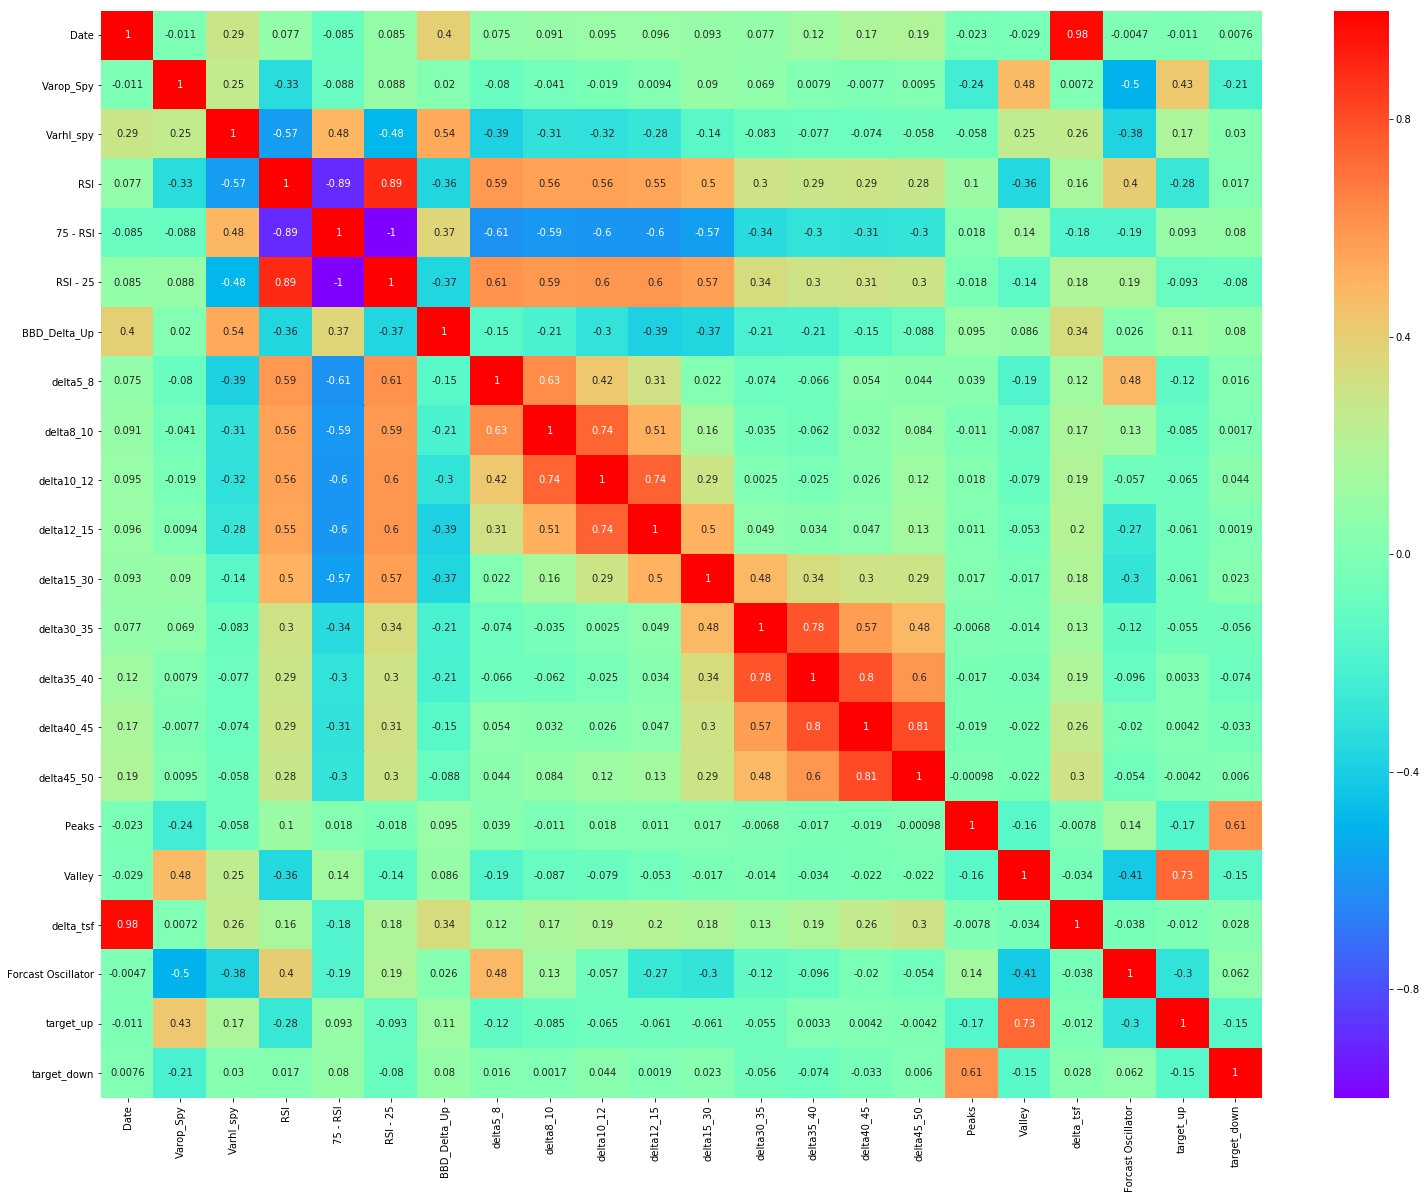

In [8]:
plt.figure(figsize=(26,20))
sns.heatmap(df_1W.iloc[:,:-1].corr(),annot=True,cmap='rainbow')
plt.show()

In [9]:
df_1W.shape

(472, 23)

In [11]:
df_1W['target_up'].sum(),df_1W['target_down'].sum()

(71, 56)

In [13]:
delta = round(df_1W.shape[0])
bloc1 = round(delta*0.8)
bloc2 = delta - bloc1
print("# of periods : ",delta)
print('On 80% - 20% slash : ')
print('Bloc 1 : ',bloc1,' periods (',df_1W.iloc[bloc1,0],')\nBloc 2 :',bloc2,' periods (',df_1W.iloc[bloc2,0],')')
print('First period :',df_1W.iloc[0,0])
print('Last period :',df_1W.iloc[df_1W.shape[0]-1,0])


# of periods :  472
On 80% - 20% slash : 
Bloc 1 :  378  periods ( 20170818 )
Bloc 2 : 94  periods ( 20120309 )
First period : 20100521
Last period : 20190531


In [14]:
X = df_1W.iloc[:,1:-4]
#X = X.drop(['Peaks','Valley'],axis=1)
#X = X.drop(['75 - RSI','RSI - 25'],axis=1)
y_up = df_1W.iloc[:,-3].values
y_down = df_1W.iloc[:,-2].values

In [15]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 472 entries, 0 to 471
Data columns (total 18 columns):
Varop_Spy       472 non-null float64
Varhl_spy       472 non-null float64
RSI             472 non-null float64
75 - RSI        472 non-null float64
RSI - 25        472 non-null float64
BBD_Delta_Up    472 non-null float64
delta5_8        472 non-null float64
delta8_10       472 non-null float64
delta10_12      472 non-null float64
delta12_15      472 non-null float64
delta15_30      472 non-null float64
delta30_35      472 non-null float64
delta35_40      472 non-null float64
delta40_45      472 non-null float64
delta45_50      472 non-null float64
Peaks           472 non-null int64
Valley          472 non-null int64
delta_tsf       472 non-null float64
dtypes: float64(16), int64(2)
memory usage: 66.5 KB


In [16]:
X.iloc[:5,[6,7]]

,delta5_8,delta8_10
0,-15.22150,-0.05250
1,-29.68550,-4.10850
2,-37.82725,-10.10575
3,-29.03275,-14.06125
4,-20.29425,-18.82175


In [17]:
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
#y_up = scaler.fit_transform(np.array(y_up).reshape(-1,1))
#y_down = scaler.fit_transform(np.array(y_down).reshape(-1,1))
y_up = np.array(y_up).reshape(-1,1)
y_down = np.array(y_down).reshape(-1,1)

In [18]:
X[:5,[6,7]]

array([[0.36914801, 0.43578958],
       [0.26413971, 0.38601416],
       [0.2050308 , 0.31241563],
       [0.26887866, 0.26387355],
       [0.33231996, 0.20545247]])

In [19]:
Xtrain = X[:bloc1,:]
Xtest = X[bloc1:,:]
ytrain_up = y_up[:bloc1,:]
ytest_up = y_up[bloc1:,:]
ytrain_down = y_down[:bloc1,:]
ytest_down = y_down[bloc1:,:]

In [20]:
Xtrain.shape,ytrain_up.shape,ytrain_down.shape,ytest_down.shape,ytest_up.shape

((378, 18), (378, 1), (378, 1), (94, 1), (94, 1))

In [21]:
model_up = XGBClassifier(silent=False,objective='binary:logistic',n_estimators=800,booster='gbtree')
eval_set_up = [(Xtrain, ytrain_up), (Xtest, ytest_up)]
history_up = model_up.fit( Xtrain, ytrain_up, eval_metric=['auc','error'], eval_set=eval_set_up, verbose=0)

In [22]:
model_down = XGBClassifier(silent=False,objective='binary:logistic',n_estimators=800)
eval_set_down = [(Xtrain, ytrain_down), (Xtest, ytest_down)]
history_down = model_down.fit( Xtrain, ytrain_down, eval_metric=['auc','error'], eval_set=eval_set_down, verbose=0)

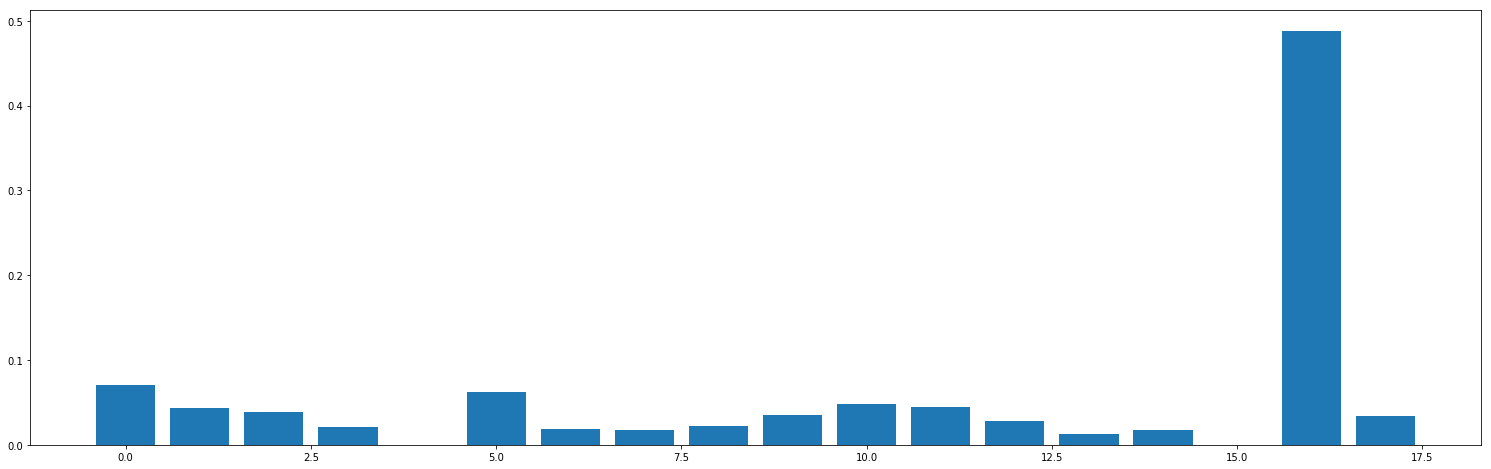

In [23]:
plt.figure(figsize=(26,8))
plt.bar(range(len(model_up.feature_importances_)), model_up.feature_importances_)
plt.show()

<Figure size 1872x1440 with 0 Axes>

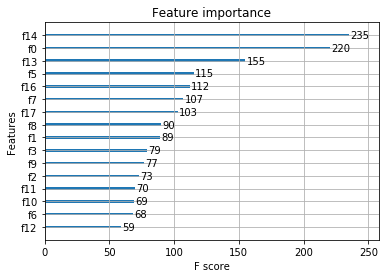

In [24]:
plt.figure(figsize=(26,20))
plot_importance(model_up)
plt.show()

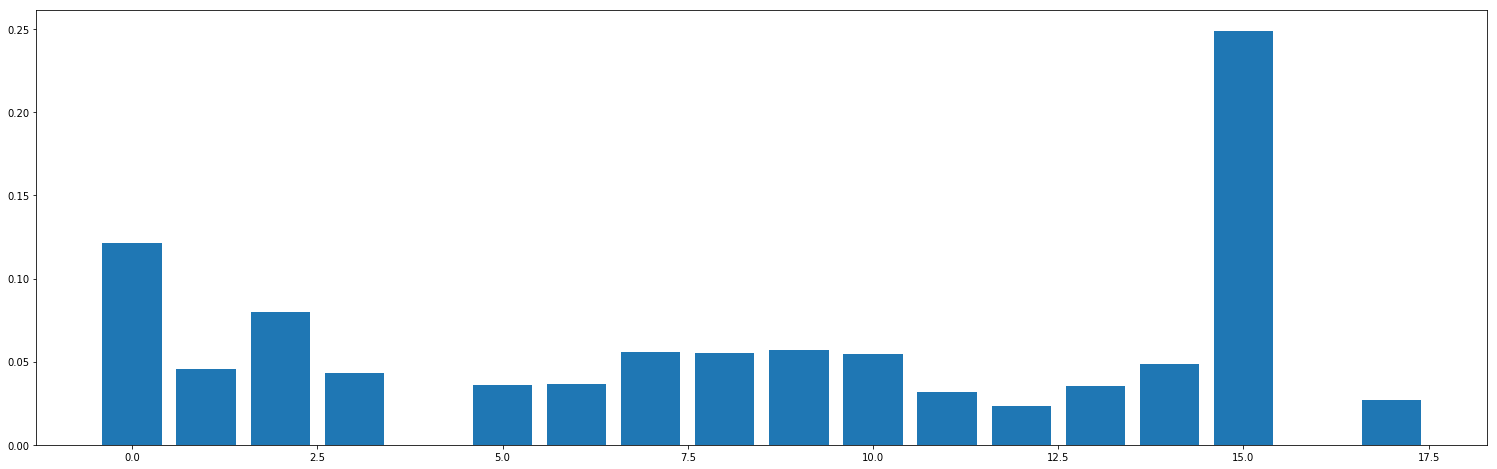

In [25]:
plt.figure(figsize=(26,8))
plt.bar(range(len(model_down.feature_importances_)), model_down.feature_importances_)
plt.show()

<Figure size 1872x1440 with 0 Axes>

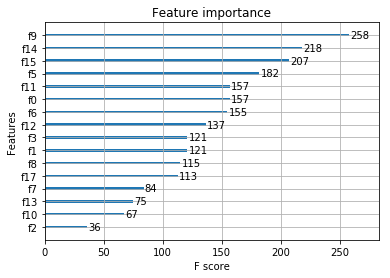

In [26]:
plt.figure(figsize=(26,20))
plot_importance(model_down)
plt.show()

In [27]:
from sklearn.feature_selection import SelectFromModel
print('Model up')
thresholds = np.sort(model_up.feature_importances_)
for thresh in range(0,len(thresholds)-1):
    selection = SelectFromModel(model_up, threshold=thresholds[thresh], prefit=True)
    select_Xtrain = selection.transform(Xtrain)
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_Xtrain, ytrain_up)
	# eval model
    select_Xtest = selection.transform(Xtest)
    y_pred = selection_model.predict(select_Xtest)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(ytest_up, predictions)
    print('If n=',thresh,' accuracy ',round(accuracy*100),'%')

Model up
If n= 0  accuracy  86.0 %
If n= 1  accuracy  86.0 %
If n= 2  accuracy  86.0 %
If n= 3  accuracy  85.0 %
If n= 4  accuracy  87.0 %
If n= 5  accuracy  87.0 %
If n= 6  accuracy  86.0 %
If n= 7  accuracy  85.0 %
If n= 8  accuracy  85.0 %
If n= 9  accuracy  86.0 %
If n= 10  accuracy  90.0 %
If n= 11  accuracy  88.0 %
If n= 12  accuracy  86.0 %
If n= 13  accuracy  88.0 %
If n= 14  accuracy  88.0 %
If n= 15  accuracy  91.0 %
If n= 16  accuracy  93.0 %


In [28]:
print('Model Down')
for thresh in range(0,len(thresholds)-1):
    selection = SelectFromModel(model_down, threshold=thresholds[thresh], prefit=True)
    select_Xtrain = selection.transform(Xtrain)
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_Xtrain, ytrain_down)
	# eval model
    select_Xtest = selection.transform(Xtest)
    y_pred = selection_model.predict(select_Xtest)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(ytest_down, predictions)
    print('If n=',thresh,' accuracy ',round(accuracy*100),'%')

Model Down
If n= 0  accuracy  91.0 %
If n= 1  accuracy  91.0 %
If n= 2  accuracy  91.0 %
If n= 3  accuracy  91.0 %
If n= 4  accuracy  91.0 %
If n= 5  accuracy  91.0 %
If n= 6  accuracy  91.0 %
If n= 7  accuracy  91.0 %
If n= 8  accuracy  93.0 %
If n= 9  accuracy  91.0 %
If n= 10  accuracy  91.0 %
If n= 11  accuracy  89.0 %
If n= 12  accuracy  91.0 %
If n= 13  accuracy  91.0 %
If n= 14  accuracy  91.0 %
If n= 15  accuracy  89.0 %
If n= 16  accuracy  89.0 %


In [29]:
yhat_up = model_up.predict(Xtest)
yhat_down = model_down.predict(Xtest)

accuracy_up = accuracy_score(ytest_up, yhat_up)
accuracy_down = accuracy_score(ytest_down, yhat_down)

# La précision permet de mesurer la capacité du modèle à refuser résultats non-pertinents : vrais_positifs/(vrais_positifs+faux_positifs)
precision_up = precision_score(ytest_up, yhat_up)  
precision_down = precision_score(ytest_down, yhat_down) 


# Recall : (vrai_positifs/(vrais_positifs+faux_négatifs))
recall_up = recall_score(ytest_up, yhat_up) 
recall_down = recall_score(ytest_down, yhat_down) 


roc_up=roc_auc_score(ytest_up,yhat_up)
roc_down=roc_auc_score(ytest_down,yhat_down)

In [30]:
print('RESULTATS UP\n')
print('Accuracy: %.2f%%' % (accuracy_up * 100.0))
print("Precision: %.2f%% " % (precision_up *100),' => Discrimnination des vrais positifs parmi les faux positifs')
print("Recall: %.2f%% " % (recall_up * 100),' => Positifs trouvés par Golem sur tous les positifs existants')
print("AUC: %.2f%% " % (roc_up *100))
# get probabilities for positive class

print(classification_report(ytest_up, yhat_up))
conf_matrix = pd.DataFrame(index = ['vrais_réels','Faux_réels'])
conf_matrix['Vrais_estimés'] = ['Vrais_positifs','Faux_positifs']
conf_matrix['Faux_estimés'] = ['Faux_négatif','Vrais-négatifs']
print(confusion_matrix(ytest_up, yhat_up))
print('Matrice de confusion :')
conf_matrix

RESULTATS UP

Accuracy: 86.17%
Precision: 71.43%   => Discrimnination des vrais positifs parmi les faux positifs
Recall: 31.25%   => Positifs trouvés par Golem sur tous les positifs existants
AUC: 64.34% 
              precision    recall  f1-score   support

           0       0.87      0.97      0.92        78
           1       0.71      0.31      0.43        16

   micro avg       0.86      0.86      0.86        94
   macro avg       0.79      0.64      0.68        94
weighted avg       0.85      0.86      0.84        94

[[76  2]
 [11  5]]
Matrice de confusion :


,Vrais_estimés,Faux_estimés
vrais_réels,Vrais_positifs,Faux_négatif
Faux_réels,Faux_positifs,Vrais-négatifs


In [31]:
print('RESULTATS DOWN\n')
print('Accuracy: %.2f%%' % (accuracy_down * 100.0))
print("Precision: %.2f%% " % (precision_down *100),' => Discrimnination des vrais positifs parmi les faux positifs')
print("Recall: %.2f%% " % (recall_down * 100),' => Positifs trouvés par Golem sur tous les positifs existants')
print("AUC: %.2f%% " % (roc_down *100))
# get probabilities for positive class

print(classification_report(ytest_down, yhat_down))
conf_matrix = pd.DataFrame(index = ['vrais_réels','Faux_réels'])
conf_matrix['Vrais_estimés'] = ['Vrais_positifs','Faux_positifs']
conf_matrix['Faux_estimés'] = ['Faux_négatif','Vrais-négatifs']
print(confusion_matrix(ytest_down, yhat_down))
print('Matrice de confusion :')
conf_matrix

RESULTATS DOWN

Accuracy: 91.49%
Precision: 83.33%   => Discrimnination des vrais positifs parmi les faux positifs
Recall: 41.67%   => Positifs trouvés par Golem sur tous les positifs existants
AUC: 70.22% 
              precision    recall  f1-score   support

           0       0.92      0.99      0.95        82
           1       0.83      0.42      0.56        12

   micro avg       0.91      0.91      0.91        94
   macro avg       0.88      0.70      0.75        94
weighted avg       0.91      0.91      0.90        94

[[81  1]
 [ 7  5]]
Matrice de confusion :


,Vrais_estimés,Faux_estimés
vrais_réels,Vrais_positifs,Faux_négatif
Faux_réels,Faux_positifs,Vrais-négatifs


In [32]:
len(df_1W)-(len(df_1W)-bloc2)

94

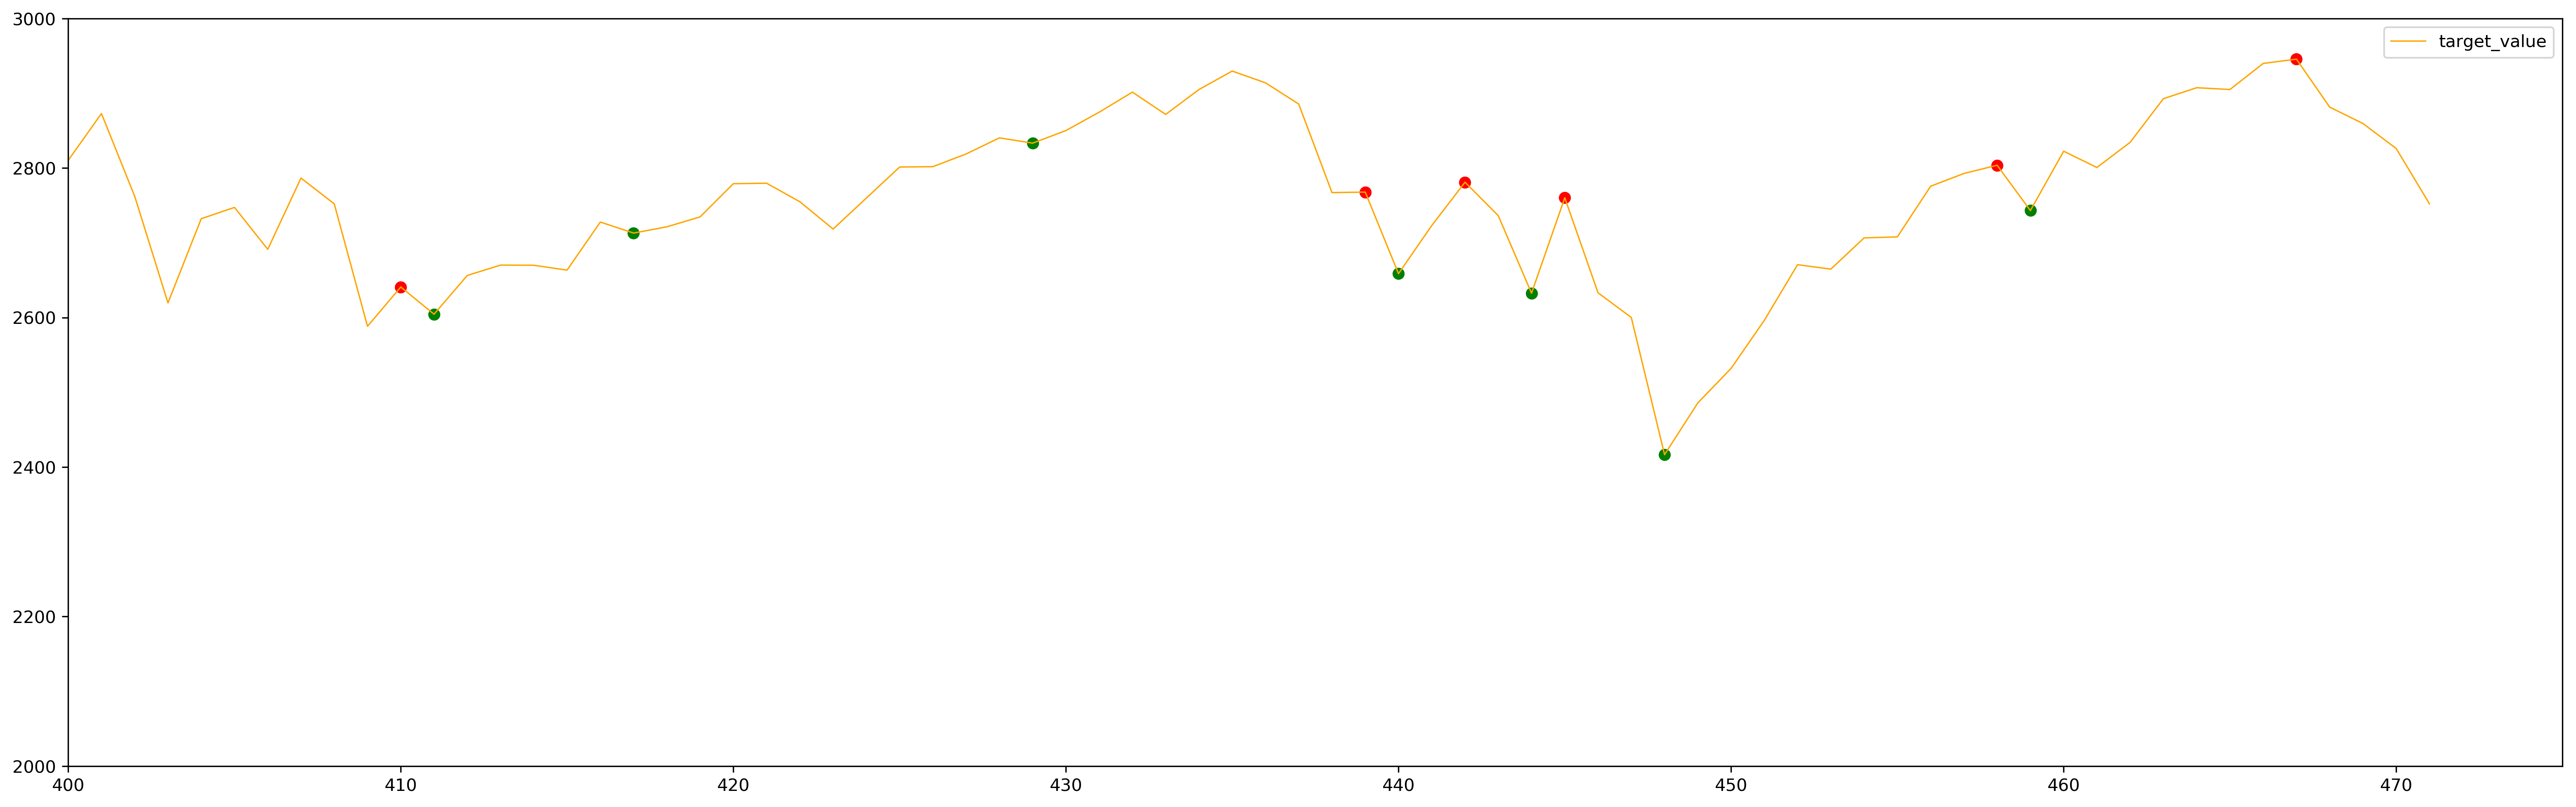

In [35]:
plt.figure(figsize=(26,8),dpi=300)
plt.plot(df_1W['target_value'],color='orange',lw=0.8)
plt.xlim(400,475)
plt.ylim(2000,3000)
a = -1
for i in range(len(df_1W)-bloc2,len(df_1W)):
    a+=1
    if yhat_up[a] == 1:
        plt.scatter(x=df_1W.index[i],y=df_1W.iloc[i,-1],c='g',marker='o')
    elif yhat_down[a] == 1:
        plt.scatter(x=df_1W.index[i],y=df_1W.iloc[i,-1],c='r',marker='o')
plt.legend()

In [36]:
sum(yhat_up),sum(yhat_down)

(7, 6)

In [37]:
# save the model to disk
filename = 'finalized_model_long.sav'
pickle.dump(model_up, open(filename, 'wb'))
filename = 'finalized_model_short.sav'
pickle.dump(model_down, open(filename, 'wb'))

# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, Y_test)
print(result)